# Description:

* number libraries = 1
* isotope incorp: 0% for all taxa (baseline)

## Goals:

* assess how fragment length affects distribution of amplicon fragments
  * fragment distributions:
    * uniform, large range
    * uniform, all small fragments
    * uniform, all large fragments
    * skewed normal, 4 kb size cutoff
    * skewed normal, 0.5 kb size cutoff

# Init

In [3]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/nl1/fragLen/'
baseDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'

In [4]:
import os,sys
import numpy as np
import pandas as pd
from ggplot import *
import matplotlib.pyplot as plt

In [5]:
%load_ext rpy2.ipython
%matplotlib inline

In [6]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(data.table)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
data.table 1.9.4  For help type: ?data.table
*** NB: by=.EACHI is now explicit. See README to restore previous behaviour.

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



In [7]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [17]:
!cd $baseDir; cut -f 1 genomes/genome_index.txt > genomes/taxon_index.txt

# Simulating gradient communities

In [118]:
!cd $workDir; \
    $SIPSimExe gradientComms \
    --abund_dist power \
    --abund_dist_p a:100 \
    $baseDir/genomes/taxon_index.txt > comm-n1-pow.txt

[1] 100
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000575 0.0248400 0.0554400 0.0826400 0.1203000 0.7323000 
[1] 12727.77


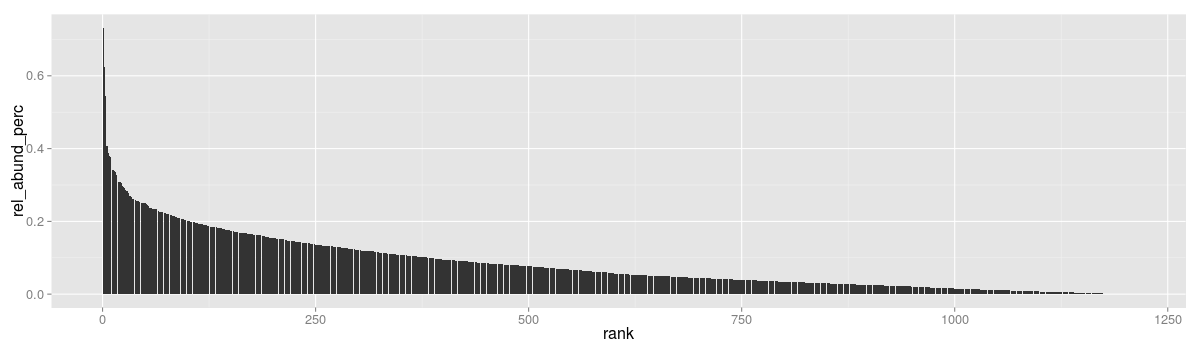

In [122]:
%%R -i workDir -w 1200 -h 350 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('comm-n1-pow.txt', sep='\t')

print(sum(tbl$rel_abund_perc))
print(summary(tbl$rel_abund_perc))
print(max(tbl$rel_abund_perc) / min(tbl$rel_abund_perc))

# plotting
ggplot(tbl, aes(rank, rel_abund_perc)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

# Simulating isotope incorporation

In [123]:
# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [126]:
!cd $workDir; \
     $SIPSimExe isoIncorp comm-n1-pow.txt incorp.config > incorp-n1-pow.txt

In [127]:
!cd $workDir; head incorp-n1-pow.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	Isosphaera_pallida_ATCC_43644	1	uniform	1.0	start	8.41134849099e-07
1	Isosphaera_pallida_ATCC_43644	1	uniform	1.0	end	3.86213774981e-06
1	Caulobacter_crescentus_NA1000	1	uniform	1.0	start	4.7095790248e-06
1	Caulobacter_crescentus_NA1000	1	uniform	1.0	end	7.22092768592e-06
1	Candidatus_Liberibacter_solanacearum_CLso-ZC1	1	uniform	1.0	start	7.47050104396e-06
1	Candidatus_Liberibacter_solanacearum_CLso-ZC1	1	uniform	1.0	end	3.75886172964e-06
1	Rickettsia_parkeri_str_Portsmouth	1	uniform	1.0	start	7.79689107526e-06
1	Rickettsia_parkeri_str_Portsmouth	1	uniform	1.0	end	6.51117262806e-06
1	Chlamydophila_abortus_S26_3	1	uniform	1.0	start	8.31779429734e-06


# Simulating gradient fractions

In [138]:
!cd $workDir; \
    $SIPSimExe fractions comm-n1-pow.txt > fracs-n1-pow.txt

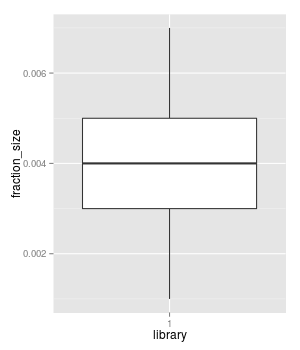

In [145]:
%%R -i workDir -h 350 -w 300 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('fracs-n1-pow.txt', sep='\t')
tbl$library = as.character(tbl$library)

#tbl.m = tbl %>% gather(min_max, BD, BD_min:BD_max )
#ggplot(tbl.m, aes(fraction, BD, group=fraction, color=min_max)) +
#    geom_point() +
#    geom_line(color='black')


ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot()

# Simulating amplicon fragments & calculating GC

## Uniform fragment length distribution: large range

In [ ]:
!cd $workDir; \
    $SIPSimExe fragGC \
    $baseDir/genomes/genome_index.txt \
    --fp $baseDir/genomes/ \
    --fr $baseDir/515Fm-927Rm.fna \
    --fld uniform,500,15000 \
    --flr 500,None \
    --nf 50x \
    --np 6 \
    > ampFragGC_unif5-150.txt

Processing: "Kangiella_koreensis_DSM_16069"
Processing: "Polymorphum_gilvum_SL003B-26A1"
Processing: "_Cellvibrio_gilvus_ATCC_13127"
Processing: "Croceibacter_atlanticus_HTCC2559"
Processing: "Sulfuricurvum_kujiense_DSM_16994"
Processing: "Eubacterium_rectale_ATCC_33656"
  Genome name: Sulfuricurvum_kujiense_DSM_16994
  Genome length (bp): 2574824
  Number of amplicons: 0
  Number of fragments simulated: 0
Processing: "Nocardia_nova_SH22a"
  Genome name: _Cellvibrio_gilvus_ATCC_13127
  Genome length (bp): 3526441
  Number of amplicons: 2
  Number of fragments simulated: 22785
  Genome name: Kangiella_koreensis_DSM_16069
  Genome length (bp): 2852073
  Number of amplicons: 2
  Number of fragments simulated: 18375
Processing: "Gordonia_polyisoprenivorans_VH2"
Processing: "Aeromonas_salmonicida_subsp_salmonicida_A449"
  Genome name: Croceibacter_atlanticus_HTCC2559
  Genome length (bp): 2952962
  Number of amplicons: 2
  Number of fragments simulated: 19050
  Genome name: Eubacterium_rect

Read 27511483 rows and 5 (of 5) columns from 2.751 GB file in 00:00:21


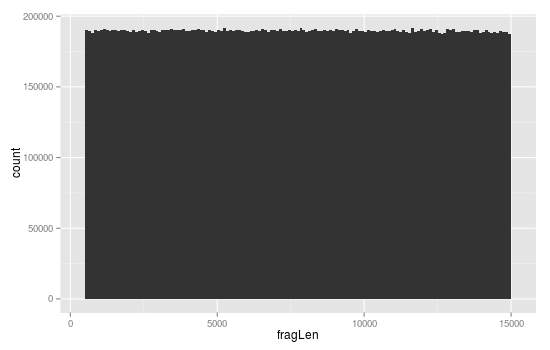

In [ ]:
%%R -i workDir -w 550 -h 350

setwd(workDir)

tbl = fread('ampFragGC_unif5-150.txt', sep="\t")
#tbl = fread('test_frag_GC.txt', '\t')

#tbl$fragLen = abs(tbl$fragEnd - tbl$fragStart)
tbl[,fragLen:=abs(fragEnd - fragStart)]
ggplot(tbl, aes(fragLen)) +
    geom_histogram(binwidth=100)

## Creating OTU table

In [ ]:
!cd $workDir; \
    $SIPSimExe OTU_table \
    ampFragGC_unif5-150.txt \
    comm-n1-pow.txt \
    incorp-n1-pow.txt \
    fracs-n1-pow.txt \
    --abs_abund 1e4 \
    > OTU-n1-exp_unif5-150_A1e4.txt

In [12]:
# TODO: 
## finish gradientComm conversion to python
## make sure fragGC is set for simulating random fragments from multiple contigs/chromosomes


***
# ~sandbox~

In [116]:
a = 1000. # shape
samples = 10000
s = np.random.power(a, samples)

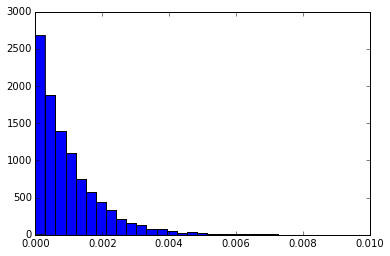

In [117]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(1 - s, bins=30)